In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score,precision_score,recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from fairlearn.metrics import selection_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.preprocessing import CorrelationRemover

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.options.display.max_columns=500


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()

In [2]:
data = fetch_openml(data_id=1590, as_frame=True)
#data = fetch_adult()

X = data.data
y = (data.target == '>50K') * 1
sex = data.data['sex']
race =data.data['race']
X_raw = data.data
A = X_raw["sex"]

df = pd.concat([X,pd.Series(y, name='>50K')], axis=1)

In [3]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,>50K
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,0


In [4]:
df['workclass']=label_encoder.fit_transform(df['workclass'])
df['marital-status']=label_encoder.fit_transform(df['marital-status'])
df['occupation']=label_encoder.fit_transform(df['occupation'])
df['relationship']=label_encoder.fit_transform(df['relationship'])
df['race']=label_encoder.fit_transform(df['race'])
df['sex']=label_encoder.fit_transform(df['sex'])
df['native-country']=label_encoder.fit_transform(df['native-country'])
df['education']=label_encoder.fit_transform(df['education'])

In [5]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,>50K
0,25.0,3,226802.0,1,7.0,4,6,3,2,1,0.0,0.0,40.0,38,0
1,38.0,3,89814.0,11,9.0,2,4,0,4,1,0.0,0.0,50.0,38,0
2,28.0,1,336951.0,7,12.0,2,10,0,4,1,0.0,0.0,40.0,38,1
3,44.0,3,160323.0,15,10.0,2,6,0,2,1,7688.0,0.0,40.0,38,1
4,18.0,8,103497.0,15,10.0,4,14,3,4,0,0.0,0.0,30.0,38,0


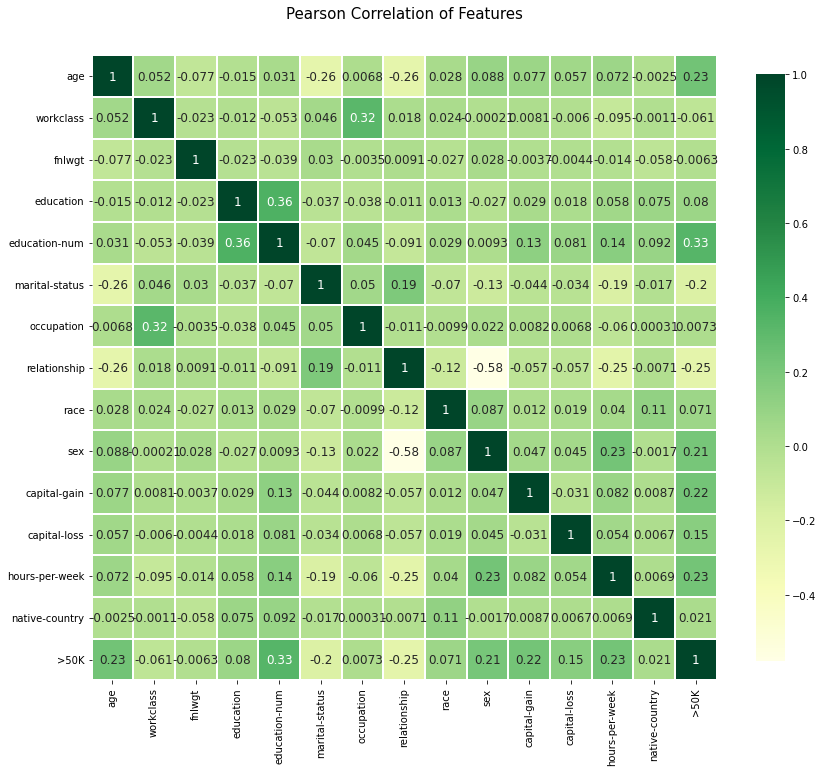

In [6]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = "YlGn",
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df)

# Our Model

In [7]:
X=df.drop('>50K',axis=1)
y=df['>50K']

In [8]:
classifier = GradientBoostingClassifier()
classifier.fit(X, y)

y_pred = classifier.predict(X)

## Fairness Assessment for the model 

# Metrics

In [9]:
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'selection_rate': selection_rate
}

# -   Sex as Sensitive Feature 

accuracy          0.868392
precision         0.796951
recall            0.603833
selection_rate    0.181299
dtype: float64
     accuracy  precision    recall  selection_rate
sex                                               
0    0.936944   0.843119  0.519503        0.067317
1    0.834395   0.790470  0.618875        0.237825


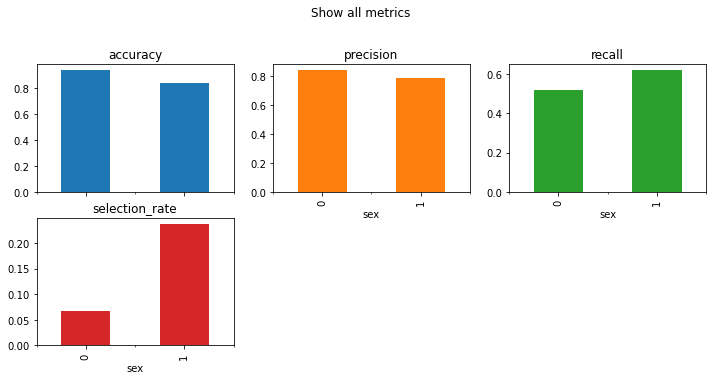

In [225]:
model_Assessmt_sex = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred, sensitive_features=df['sex'])
model_Assessmt_sex.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
   
)
print(model_Assessmt_sex.overall)
print(model_Assessmt_sex.by_group)

# -   Race as Sensitive Feature 

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='race'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='race'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='race'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='race'>,
        <AxesSubplot:xlabel='race'>, <AxesSubplot:xlabel='race'>],
       [<AxesSubplot:xlabel='race'>, <AxesSubplot:xlabel='race'>,
        <AxesSubplot:xlabel='race'>]], dtype=object)

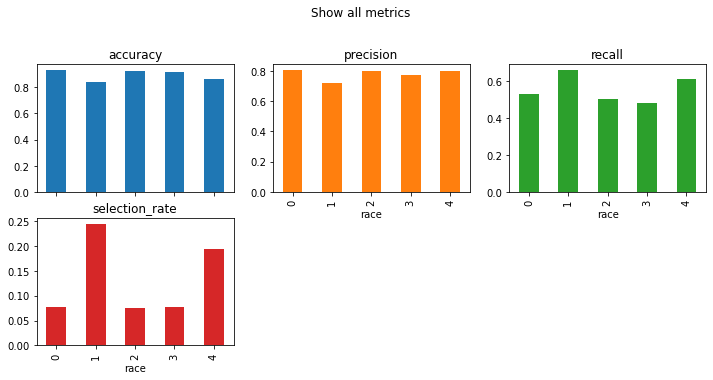

In [227]:
model_Assessmt_race = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred, sensitive_features=df['race'])
model_Assessmt_race.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
   
)


# -   Race Plus Sex as Sensitive Feature

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='sex,race'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='sex,race'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='sex,race'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='sex,race'>,
        <AxesSubplot:xlabel='sex,race'>, <AxesSubplot:xlabel='sex,race'>],
       [<AxesSubplot:xlabel='sex,race'>, <AxesSubplot:xlabel='sex,race'>,
        <AxesSubplot:xlabel='sex,race'>]], dtype=object)

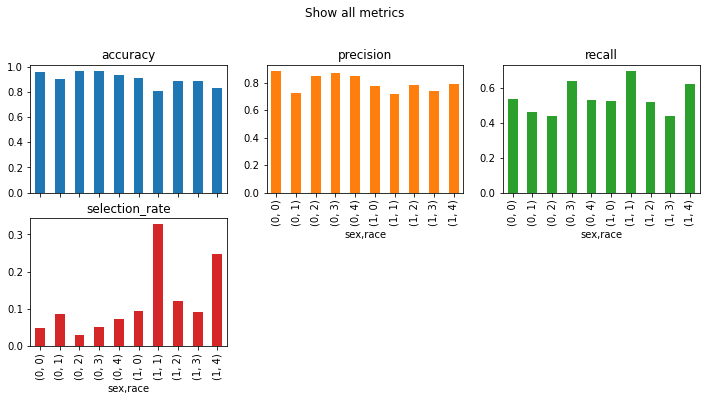

In [12]:
mfm = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred, sensitive_features=df[['sex','race']])
mfm.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
   
)

# 2.   Democratic Parity Differences

## 2.1 Democratic Parity Differences for Sex

In [13]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred,
                                    sensitive_features=df['sex']))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred,
                               sensitive_features=df['sex']))

0.1705082274573419
0.283052977916006


## 2.2 Democratic Parity Differences for Race

In [14]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred,
                                    sensitive_features=df['race']))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred,
                               sensitive_features=df['race']))

0.16891076601398297
0.31028103877623625


## 2.3 Democratic Parity Differences for Sex Plus Race

In [15]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred,
                                    sensitive_features=df[['sex','race']]))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred,
                               sensitive_features=df[['sex','race']]))

0.29788257107967775
0.09000507249439912


## 2.4  Heatmap and bar chart for Democratic Parity Differences 

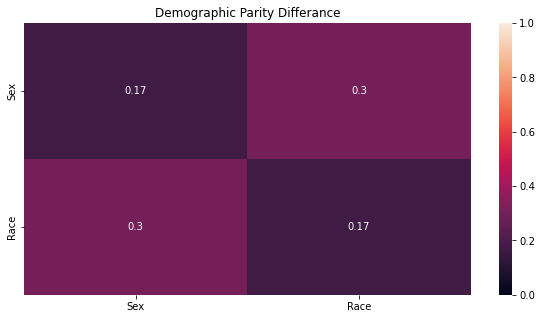

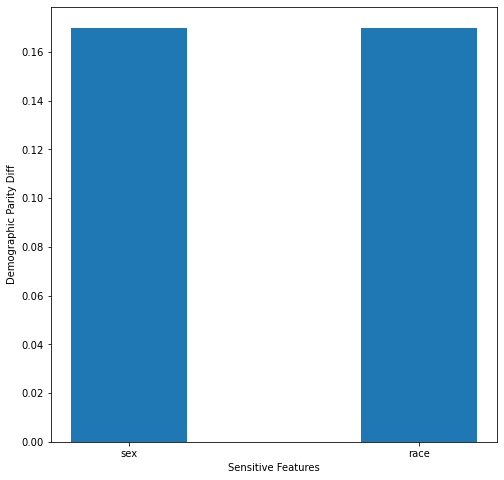

In [16]:
data_diffrances=[[0.17,0.30],[0.30,0.17]]
labels = ['Sex','Race']
df_CM = pd.DataFrame(data_diffrances, index = labels, columns = labels)
plt.figure(figsize = (10,5))
plt.title('Demographic Parity Differance')
sns.heatmap(df_CM, annot = True, vmin = 0, vmax = 1)
data_diagonal={'sex':0.17, 'race':0.17}
keys = list(data_diagonal.keys())
values = list(data_diagonal.values())
fig = plt.figure(figsize = (8,8))
plt.bar(keys, values, width = 0.4)
plt.xlabel('Sensitive Features')
plt.ylabel('Demographic Parity Diff')

plt.show()

#                               3. MITIGATION 

## 3.1 Parallel Mitigation 

-    Executing Matigation Algorithms independently from each other.  

# 1)  Pre-processing

##   A- CorrelationRemover

 ###   a ) Sex as Sensitive Feature

In [17]:
crp_sex = CorrelationRemover(sensitive_feature_ids=['sex'])
crp_sex.fit(X)
X_transform_sexp = crp_sex.transform(X)
classifierp = GradientBoostingClassifier()
classifierp.fit(X_transform_sexp, y)
y_pred_sexp = classifierp.predict(X_transform_sexp)

 ###   b ) Testing Fairness

accuracy          0.866058
precision         0.794303
recall            0.594079
selection_rate    0.178965
dtype: float64


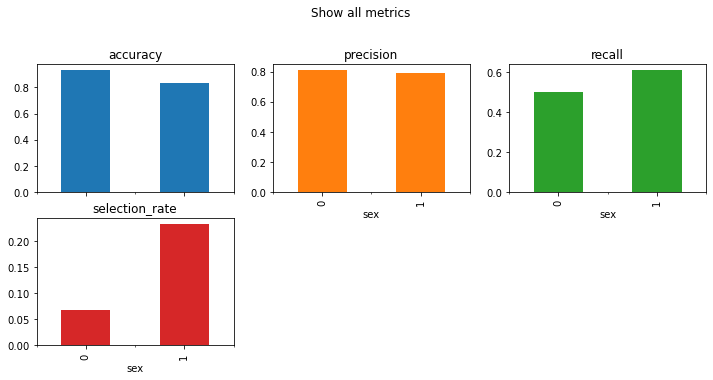

In [228]:
Metric_Corr_Para_sex = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=y_pred_sexp,
                           sensitive_features= df['sex'])
Metric_Corr_Para_sex.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)
print(Metric_Corr_Para_sex.overall)

 ###   c ) Race as Sensitive Feature

In [20]:
crp_race = CorrelationRemover(sensitive_feature_ids=['race'])
crp_race.fit(X)

X_transform_racep = crp_race.transform(X)
classifierpr = GradientBoostingClassifier()
classifierpr.fit(X_transform_racep, y)

y_pred_racep = classifierpr.predict(X_transform_racep)

 ###   d ) Testing Fairness

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='race'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='race'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='race'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='race'>,
        <AxesSubplot:xlabel='race'>, <AxesSubplot:xlabel='race'>],
       [<AxesSubplot:xlabel='race'>, <AxesSubplot:xlabel='race'>,
        <AxesSubplot:xlabel='race'>]], dtype=object)

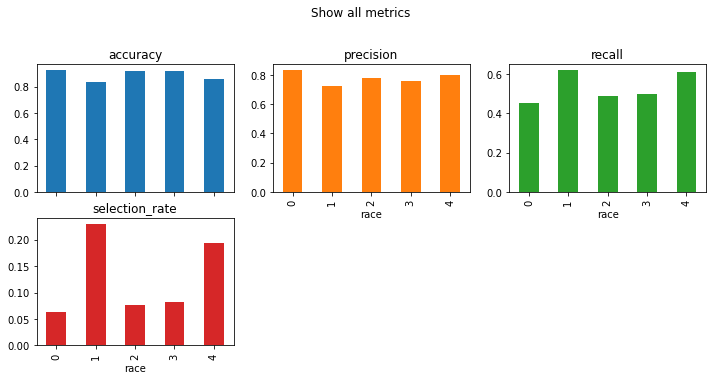

In [21]:
Metric_Corr_Para_race = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=y_pred_racep,
                           sensitive_features= df[['race']])
Metric_Corr_Para_race.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

 ###   e ) Race&Sex as Sensitive Feature

In [22]:
crp_racesex = CorrelationRemover(sensitive_feature_ids=['race','sex'])
crp_racesex.fit(X)

X_transform_racesexp = crp_racesex.transform(X)
classifierprs = GradientBoostingClassifier()
classifierprs.fit(X_transform_racesexp, y)

y_pred_racesexp = classifierprs.predict(X_transform_racesexp)

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='race,sex'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='race,sex'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='race,sex'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='race,sex'>,
        <AxesSubplot:xlabel='race,sex'>, <AxesSubplot:xlabel='race,sex'>],
       [<AxesSubplot:xlabel='race,sex'>, <AxesSubplot:xlabel='race,sex'>,
        <AxesSubplot:xlabel='race,sex'>]], dtype=object)

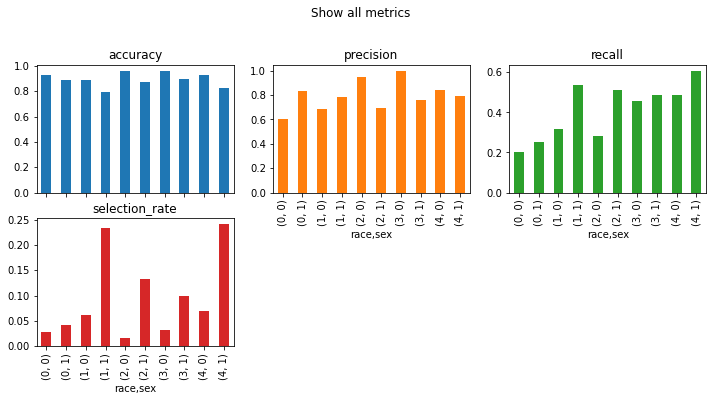

In [23]:
Metric_Corr_Para_racesex = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=y_pred_racesexp,
                           sensitive_features= df[['race','sex']])
Metric_Corr_Para_racesex.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

# B) Democratic Parity Differences 


 ###   a ) Sex as Sensitive Feature

In [24]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_sexp,
                                    sensitive_features=df['sex']))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_sexp,
                               sensitive_features=df['sex']))

0.16627755600481814
0.2896817737070113


 ###   b ) Race as Sensitive Feature

In [25]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_racep,
                                    sensitive_features=df["race"]))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_racep,
                               sensitive_features=df["race"]))

0.16658495930973627
0.27702127659574466


 ###   c ) Race&Sex as Sensitive Feature

In [26]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_racesexp,
                                    sensitive_features=df[["race",'sex']]))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_racesexp,
                               sensitive_features=df[["race",'sex']])) 

0.22441076182012226
0.0700254916496664


## Heat map for Democratic Parity Differences for sex and race After Removing Possible Correlation

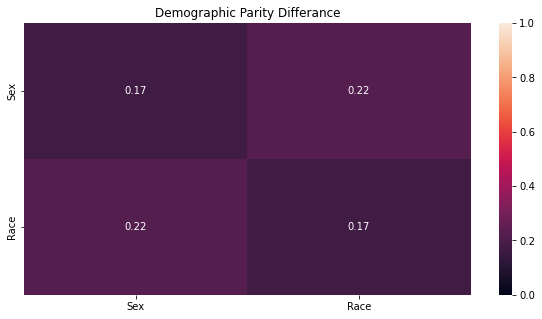

In [27]:
data_diffrances=[[0.17,0.22],[0.22,0.17]]
labels = ['Sex','Race']
df_CM = pd.DataFrame(data_diffrances, index = labels, columns = labels)
plt.figure(figsize = (10,5))
plt.title('Demographic Parity Differance')
sns.heatmap(df_CM, annot = True, vmin = 0, vmax = 1)
plt.show()

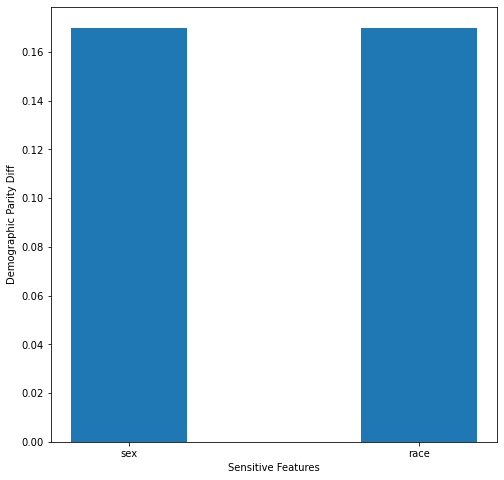

In [28]:
data_diagonal={'sex':0.17, 'race':0.17}
keys = list(data_diagonal.keys())
values = list(data_diagonal.values())
fig = plt.figure(figsize = (8,8))
plt.bar(keys, values, width = 0.4)
plt.xlabel('Sensitive Features')
plt.ylabel('Demographic Parity Diff')
plt.show()

#  2 )  In-processing

## 2.1 ExponentiatedGradient

 ###   a ) Sex as Sensitive Feature

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>],
       [<AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>]], dtype=object)

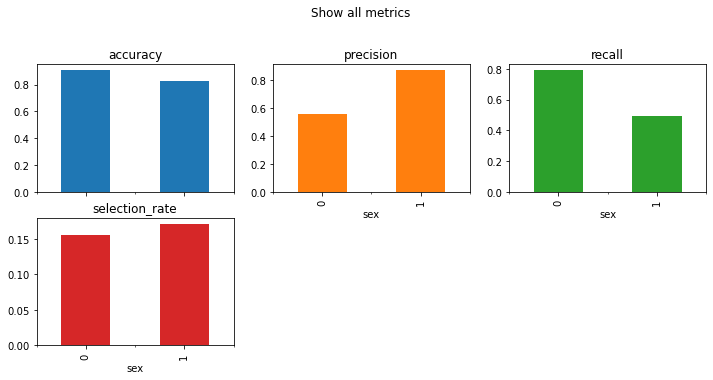

In [29]:
#ExponentiatedGradient
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = GradientBoostingClassifier()
mitigatorP = ExponentiatedGradient(classifier, constraint)
mitigatorP.fit(X, y, sensitive_features=df[['sex']])
y_pred_mitigatedP = mitigatorP.predict(X)

eg_sex_mitigated = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred_mitigatedP, sensitive_features=df[['sex']])


eg_sex_mitigated.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [229]:
print(eg_sex_mitigated.overall)
print(eg_sex_mitigated.by_group)

accuracy          0.851746
precision         0.773499
recall            0.537948
selection_rate    0.166414
dtype: float64
     accuracy  precision    recall  selection_rate
sex                                               
0    0.908041   0.555511  0.791973        0.155756
1    0.823828   0.871566  0.492640        0.171700


 ###   b ) race as Sensitive Feature

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='race'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='race'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='race'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='race'>,
        <AxesSubplot:xlabel='race'>, <AxesSubplot:xlabel='race'>],
       [<AxesSubplot:xlabel='race'>, <AxesSubplot:xlabel='race'>,
        <AxesSubplot:xlabel='race'>]], dtype=object)

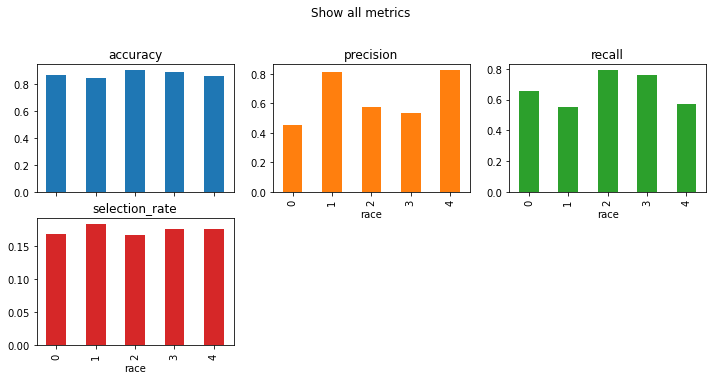

In [30]:
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint1 = DemographicParity()
classifier1 = GradientBoostingClassifier()
mitigatorpr = ExponentiatedGradient(classifier1, constraint1)
mitigatorpr.fit(X, y, sensitive_features=df[['race']])
y_pred_mitigatedP_r = mitigatorpr.predict(X)

eg_race_mitigated = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred_mitigatedP_r, sensitive_features=df[['race']])


eg_race_mitigated.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

###   c ) race&sex as Sensitive Feature

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='race,sex'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='race,sex'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='race,sex'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='race,sex'>,
        <AxesSubplot:xlabel='race,sex'>, <AxesSubplot:xlabel='race,sex'>],
       [<AxesSubplot:xlabel='race,sex'>, <AxesSubplot:xlabel='race,sex'>,
        <AxesSubplot:xlabel='race,sex'>]], dtype=object)

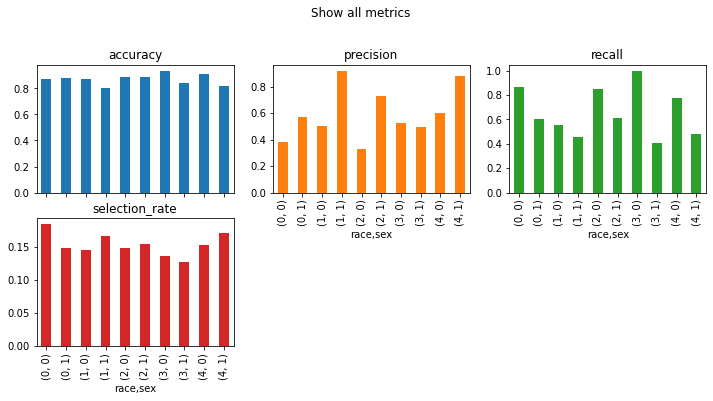

In [31]:
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint2 = DemographicParity()
classifier2 = GradientBoostingClassifier()
mitigatorprs = ExponentiatedGradient(classifier2, constraint2)
mitigatorprs.fit(X, y, sensitive_features=df[['race','sex']])
y_pred_mitigatedp_rs = mitigatorprs.predict(X)

rst_mitigatedp = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred_mitigatedp_rs, sensitive_features=df[['race','sex']])


rst_mitigatedp.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

## 2.2 Democratic Parity Differences 

 ###   a ) Sex as Sensitive Feature

In [32]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_mitigatedP,
                                    sensitive_features=df['sex']))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_mitigatedP,
                               sensitive_features=df['sex']))

0.01594391800688824
0.9071407558107561


 ###   b ) race as Sensitive Feature

In [33]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_mitigatedP_r,
                                    sensitive_features=df["race"]))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_mitigatedP_r,
                               sensitive_features=df["race"]))

0.017184675364275925
0.9064389896833867


 ###   c ) race&sex as Sensitive Feature

In [34]:

from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_mitigatedp_rs,
                                    sensitive_features=df[["race",'sex']]))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_mitigatedp_rs,
                               sensitive_features=df[["race",'sex']]))

0.056293743943146346
0.6936958050152331


## Heat map for Democratic Parity Differences for sex and race Mitigation 

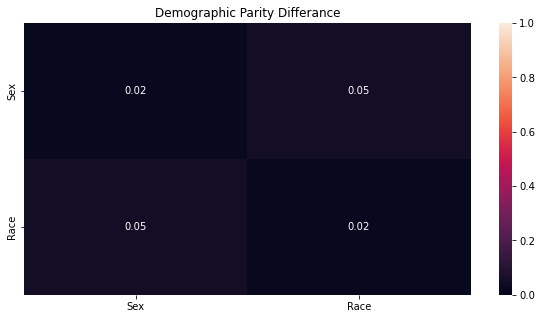

In [35]:
data_diffrances=[[0.02,0.05],[0.05,0.02]]
labels = ['Sex','Race']
df_CM = pd.DataFrame(data_diffrances, index = labels, columns = labels)
plt.figure(figsize = (10,5))
plt.title('Demographic Parity Differance')
sns.heatmap(df_CM, annot = True, vmin = 0, vmax = 1)
plt.show()

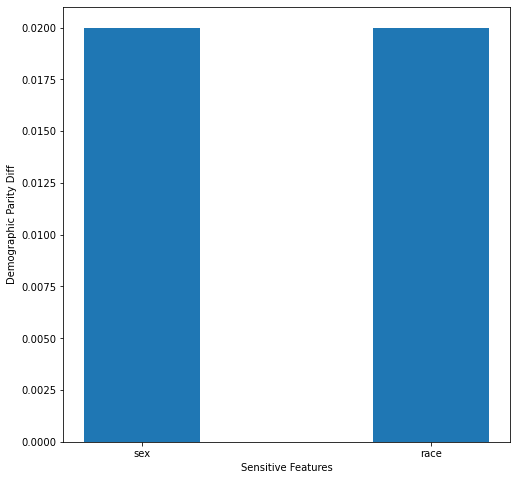

In [36]:
data_diagonal={'sex':0.02, 'race':0.02}
keys = list(data_diagonal.keys())
values = list(data_diagonal.values())
fig = plt.figure(figsize = (8,8))
plt.bar(keys, values, width = 0.4)
plt.xlabel('Sensitive Features')
plt.ylabel('Demographic Parity Diff')
plt.show()

# 2.3 GridSearch 

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from fairlearn.reductions import DemographicParity, GridSearch, EqualizedOdds

 ###   a ) Sex as Sensitive Feature

In [38]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [39]:
GSp=GridSearch(
    LogisticRegression(solver="liblinear", fit_intercept=True),
    constraints=DemographicParity(),
    grid_size=31,
)
    
GSp.fit(X, y, sensitive_features=df[['sex']])
predictors1 = GSp.predictors_
y_pred_GSp_sex_mitigated = GSp.predict(X)


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>],
       [<AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>]], dtype=object)

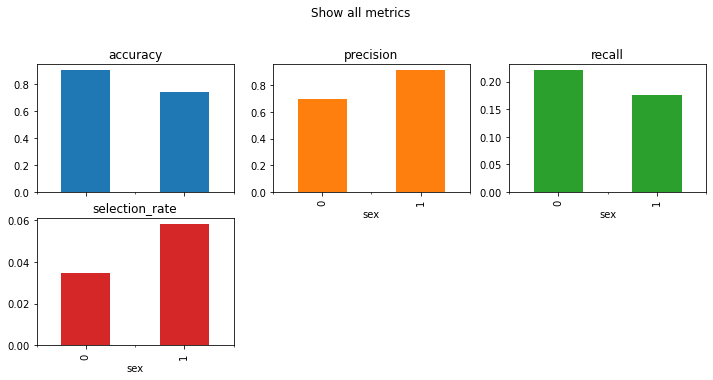

In [40]:
 GS_mitigatedp_sex = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred_GSp_sex_mitigated, sensitive_features=df[['sex']])
GS_mitigatedp_sex.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
   title="Show all metrics",
)

 ###   b ) race as Sensitive Feature

In [41]:
GSp=GridSearch(
    LogisticRegression(solver="liblinear", fit_intercept=True),
    constraints=DemographicParity(),
    grid_size=31,
)
GSp.fit(X, y, sensitive_features=df[['race']])
predictors12 = GSp.predictors_
y_pred_GSp_race_mitigated = GSp.predict(X)

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='race'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='race'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='race'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='race'>,
        <AxesSubplot:xlabel='race'>, <AxesSubplot:xlabel='race'>],
       [<AxesSubplot:xlabel='race'>, <AxesSubplot:xlabel='race'>,
        <AxesSubplot:xlabel='race'>]], dtype=object)

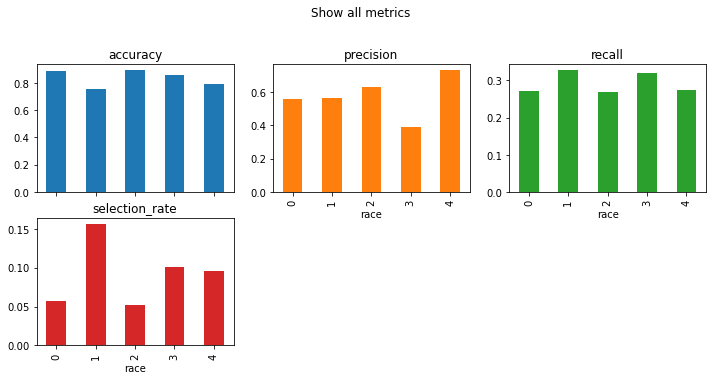

In [42]:
 GS_mitigatedp_race = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred_GSp_race_mitigated, sensitive_features=df[['race']])
GS_mitigatedp_race.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
   title="Show all metrics",
)

 ###   c ) Sex&race as Sensitive Feature

In [43]:
GSp=GridSearch(
    LogisticRegression(solver="liblinear", fit_intercept=True),
    constraints=DemographicParity(),
    grid_size=31,
)
GSp.fit(X, y, sensitive_features=df[["race",'sex']])
predictors1 = GSp.predictors_
y_pred_GSp_sexrace_mitigated = GSp.predict(X)

The grid has 9 dimensions. It is not recommended to use more than 4, otherwise a prohibitively large grid size is required to explore the space thoroughly. For such cases consider using ExponentiatedGradient from the fairlearn.reductions module.
Generating a grid with 31 grid points. It is recommended to use at least 512 grid points. Please consider increasing grid_size.
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='race,sex'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='race,sex'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='race,sex'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='race,sex'>,
        <AxesSubplot:xlabel='race,sex'>, <AxesSubplot:xlabel='race,sex'>],
       [<AxesSubplot:xlabel='race,sex'>, <AxesSubplot:xlabel='race,sex'>,
        <AxesSubplot:xlabel='race,sex'>]], dtype=object)

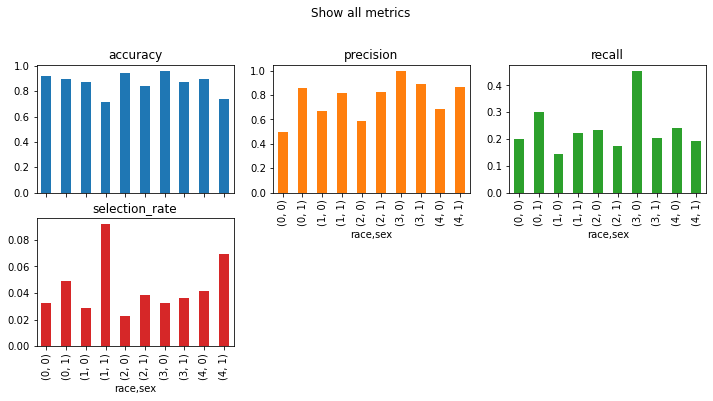

In [44]:
 GS_mitigatedp_sexrace = MetricFrame(metrics=metrics, y_true=y, y_pred=y_pred_GSp_sexrace_mitigated, sensitive_features=df[["race",'sex']])
GS_mitigatedp_sexrace.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
   title="Show all metrics",
)

## 2.4 Democratic Parity Differences 

 ###   a ) Sex as Sensitive Feature

In [45]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_GSp_sex_mitigated,
                                    sensitive_features=df['sex']))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_GSp_sex_mitigated,
                               sensitive_features=df['sex']))

0.023607472201877623
0.5947508057879578


 ###  b ) race as Sensitive Feature

In [46]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_GSp_race_mitigated,
                                    sensitive_features=df['sex']))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_GSp_race_mitigated,
                               sensitive_features=df['sex']))

0.05624237329685429
0.49537964052149147


 ###   c ) Sex&race as Sensitive Feature

In [47]:

from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=y_pred_GSp_sexrace_mitigated,
                                    sensitive_features=df[["race",'sex']]))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=y_pred_GSp_sexrace_mitigated,
                               sensitive_features=df[["race",'sex']]))

0.06885276241278275
0.25010360937382264


## Heat map for Democratic Parity Differences for sex and race Mitigation

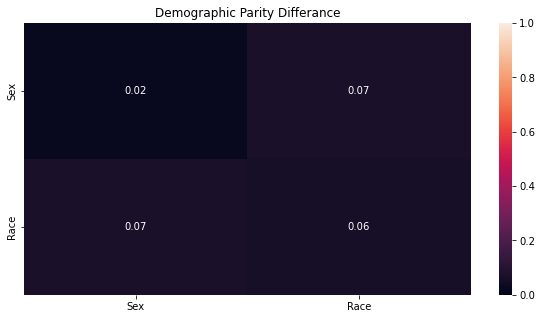

In [48]:
data_diffrances=[[0.02,0.07],[0.07,0.06]]
labels = ['Sex','Race']
df_CM = pd.DataFrame(data_diffrances, index = labels, columns = labels)
plt.figure(figsize = (10,5))
plt.title('Demographic Parity Differance')
sns.heatmap(df_CM, annot = True, vmin = 0, vmax = 1)
plt.show()

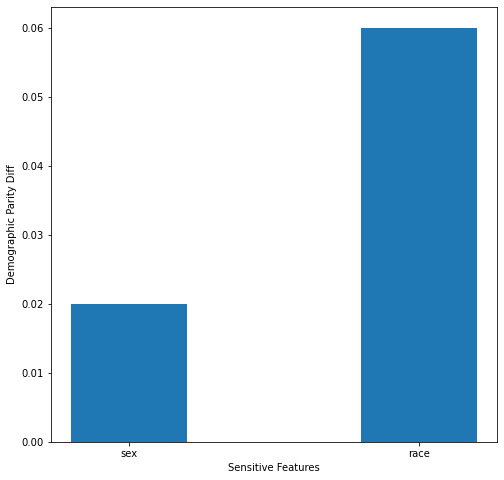

In [49]:
data_diagonal={'sex':0.02, 'race':0.06}
keys = list(data_diagonal.keys())
values = list(data_diagonal.values())
fig = plt.figure(figsize = (8,8))
plt.bar(keys, values, width = 0.4)
plt.xlabel('Sensitive Features')
plt.ylabel('Demographic Parity Diff')
plt.show()

#  3 )  Post-processing

# 3.1 - ThresholdOptimizer

In [50]:
from fairlearn.postprocessing import ThresholdOptimizer

In [51]:
optimizer2 = ThresholdOptimizer(estimator=classifier, constraints='demographic_parity')

 ###  a ) sex as Sensitive Feature

In [52]:
optimizer2.fit(X,y,sensitive_features=df[['sex']])

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


ThresholdOptimizer(estimator=GradientBoostingClassifier())

In [53]:

thp_sex_y_pred = optimizer2.predict(X,sensitive_features=df[['sex']])

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>],
       [<AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>]], dtype=object)

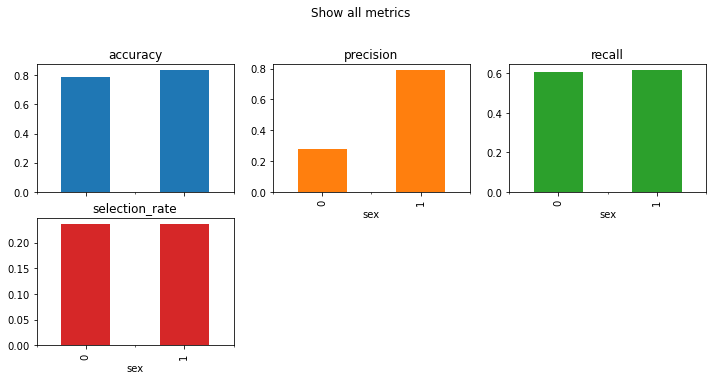

In [54]:
metric_frame_thp_sex = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=thp_sex_y_pred,
                           sensitive_features=df[['sex']])
metric_frame_thp_sex.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

 ###  b ) race as Sensitive Feature

In [55]:
optimizer2.fit(X,y,sensitive_features=df[['race']])

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


ThresholdOptimizer(estimator=GradientBoostingClassifier())

In [56]:

thp_race_y_pred = optimizer2.predict(X,sensitive_features=df[['race']])

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='race'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='race'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='race'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='race'>,
        <AxesSubplot:xlabel='race'>, <AxesSubplot:xlabel='race'>],
       [<AxesSubplot:xlabel='race'>, <AxesSubplot:xlabel='race'>,
        <AxesSubplot:xlabel='race'>]], dtype=object)

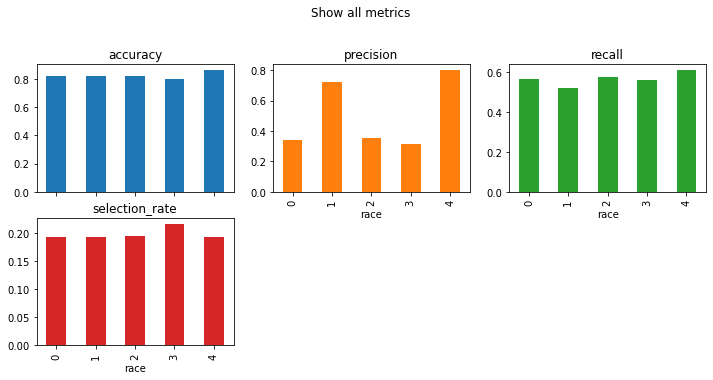

In [57]:
metric_frame_thp_race = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=thp_race_y_pred,
                           sensitive_features=df[['race']])
metric_frame_thp_race.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

 ###  c ) sexrace as Sensitive Feature

In [58]:
optimizer2.fit(X,y,sensitive_features=df[['race','sex']])

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


ThresholdOptimizer(estimator=GradientBoostingClassifier())

In [59]:
thp_racesex_y_pred = optimizer2.predict(X,sensitive_features=df[['race','sex']])

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='race,sex'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='race,sex'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='race,sex'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='race,sex'>,
        <AxesSubplot:xlabel='race,sex'>, <AxesSubplot:xlabel='race,sex'>],
       [<AxesSubplot:xlabel='race,sex'>, <AxesSubplot:xlabel='race,sex'>,
        <AxesSubplot:xlabel='race,sex'>]], dtype=object)

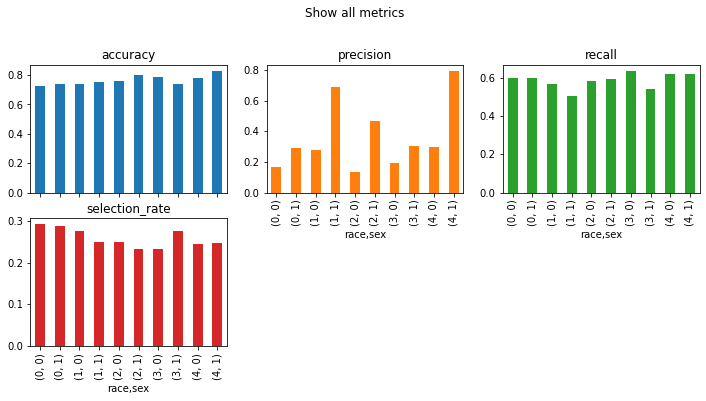

In [60]:
metric_frame_thp_racesex = MetricFrame(metrics=metrics,
                           y_true=y,
                           y_pred=thp_racesex_y_pred,
                           sensitive_features=df[['race','sex']])
metric_frame_thp_racesex.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

## 3.2 Democratic Parity Differences 

 ###  a ) sex as Sensitive Feature

In [61]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=thp_sex_y_pred,
                                    sensitive_features=df['sex']))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=thp_sex_y_pred,
                               sensitive_features=df['sex']))

0.0002163812201514681
0.9990862846821075


Demographic parity differences, Sex as Sensitive Feature = 0.0002163812201514681
Demographic parity differences, Race as Sensitive Feature =  0.023858709223400165
Demographic parity differences, (Race and Sex) as Sensitive Feature  =  0.060507794289872546


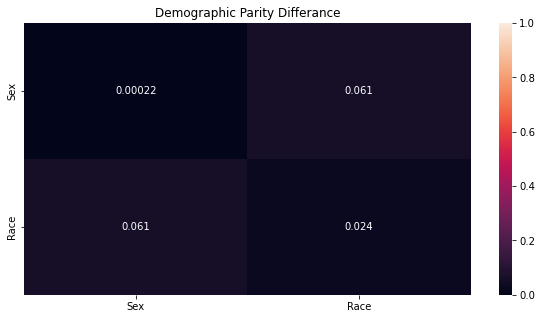

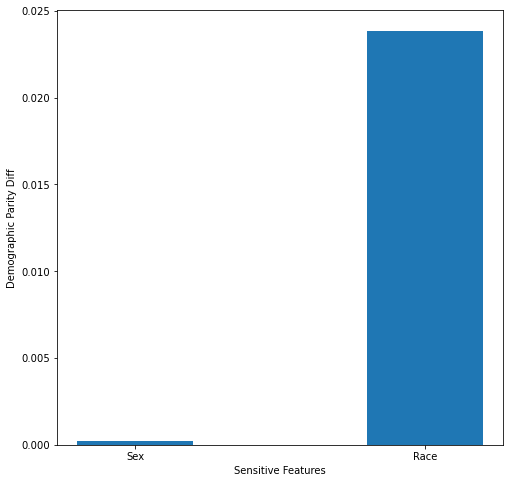

In [62]:
from fairlearn.metrics import demographic_parity_difference

dmpds = demographic_parity_difference(y_true=y,
                                    y_pred=thp_sex_y_pred,
                                    sensitive_features=df['sex'])
print('Demographic parity differences, Sex as Sensitive Feature =',dmpds)
dmpdr = demographic_parity_difference(y_true=y,
                                    y_pred=thp_race_y_pred,
                                     sensitive_features=df['race'])
print('Demographic parity differences, Race as Sensitive Feature = ',dmpdr)
dmpdrs = demographic_parity_difference(y_true=y,
                                    y_pred=thp_racesex_y_pred,
                                    sensitive_features=df[["race",'sex']])

print('Demographic parity differences, (Race and Sex) as Sensitive Feature  = ',dmpdrs) 


data_diffrances=[[dmpds,dmpdrs],[dmpdrs,dmpdr]]
labels = ['Sex','Race']
df_CM = pd.DataFrame(data_diffrances, index = labels, columns = labels)
plt.figure(figsize = (10,5))
plt.title('Demographic Parity Differance')
sns.heatmap(df_CM, annot = True, vmin = 0, vmax = 1)
plt.show()

data_diagonal={'Sex':dmpds, 'Race':dmpdr}
keys = list(data_diagonal.keys())
values = list(data_diagonal.values())
fig = plt.figure(figsize = (8,8))
plt.bar(keys, values, width = 0.4)
plt.xlabel('Sensitive Features')
plt.ylabel('Demographic Parity Diff')
plt.show()

 ###  b ) race as Sensitive Feature

In [63]:
from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=thp_race_y_pred,
                                    sensitive_features=df['race']))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=thp_race_y_pred,
                               sensitive_features=df['race']))

0.023858709223400165
0.8899245915374947


 ###  c ) sexrace as Sensitive Feature

In [64]:

from fairlearn.metrics import demographic_parity_difference
print(demographic_parity_difference(y_true=y,
                                    y_pred=thp_racesex_y_pred,
                                    sensitive_features=df[["race",'sex']]))
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true=y,
                               y_pred=thp_racesex_y_pred,
                               sensitive_features=df[["race",'sex']]))

0.060507794289872546
0.792704778821733


## Heat map for Democratic Parity Differences for sex and race Mitigation

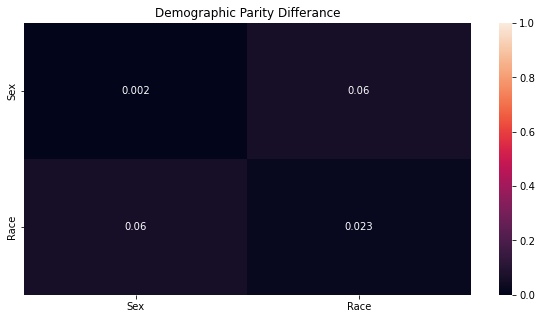

In [65]:
data_diffrances=[[0.002,0.06],[0.06,0.023]]
labels = ['Sex','Race']
df_CM = pd.DataFrame(data_diffrances, index = labels, columns = labels)
plt.figure(figsize = (10,5))
plt.title('Demographic Parity Differance')
sns.heatmap(df_CM, annot = True, vmin = 0, vmax = 1)
plt.show()

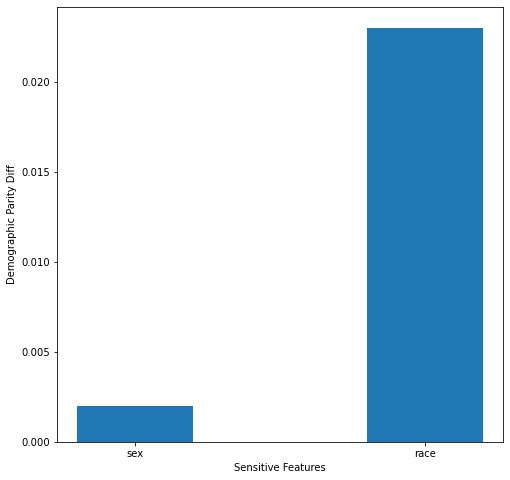

In [66]:
data_diagonal={'sex':0.002, 'race':0.023}
keys = list(data_diagonal.keys())
values = list(data_diagonal.values())
fig = plt.figure(figsize = (8,8))
plt.bar(keys, values, width = 0.4)
plt.xlabel('Sensitive Features')
plt.ylabel('Demographic Parity Diff')
plt.show()

# 3.2 Mitigation in Series 

# 1 ) CorrelationRemover + ExponentiateGradient

In [138]:
X_s=df.drop('>50K',axis=1)
y_s=df['>50K']
classifier = GradientBoostingClassifier()
classifier.fit(X_s, y_s)
y_pred_s = classifier.predict(X_s)

In [2]:
from fairlearn.metrics import MetricFrame

## CorrelationRemover

# Sex

In [141]:
cr_sex_s1 = CorrelationRemover(sensitive_feature_ids=['sex'])
cr_sex_s1.fit(X_s)

X_transform_sex_s = cr_sex_s1.transform(X_s)

classifier = GradientBoostingClassifier()
classifier.fit(X_transform_sex_s, y_s)

y_pred_sex_s = classifier.predict(X_transform_sex_s)

# Race

In [143]:
cr_race_s1 = CorrelationRemover(sensitive_feature_ids=['race'])
cr_race_s1.fit(X_s)

X_transform_race_s = cr_race_s1.transform(X_s)

classifier1 = GradientBoostingClassifier()
classifier1.fit(X_transform_race_s, y_s)

y_pred_race_s = classifier1.predict(X_transform_race_s)

# Race&Sex


In [145]:
cr_race_sex_s1 = CorrelationRemover(sensitive_feature_ids=['race','sex'])
cr_race_sex_s1.fit(X_s)

X_transform_race_sex_s = cr_race_sex_s1.transform(X_s)

classifier2 = GradientBoostingClassifier()
classifier2.fit(X_transform_race_sex_s, y_s)

y_pred_race_sex_s = classifier2.predict(X_transform_race_sex_s)

# ExponentiatedGradient

# Sex

In [149]:
#ExponentiatedGradient
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = GradientBoostingClassifier()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X_transform_sex_s, y_s, sensitive_features=df[['sex']])
y_pred_mitigated_sex_s = mitigator.predict(X_transform_sex_s)

# Race

In [151]:
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = GradientBoostingClassifier()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X_transform_race_s, y_s, sensitive_features=df[['race']])
y_pred_mitigated_race_s = mitigator.predict(X_transform_race_s)

# Race&Sex

In [153]:
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = GradientBoostingClassifier()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X_transform_race_sex_s, y_s, sensitive_features=df[['race','sex']])
y_pred_mitigated_race_sex_s = mitigator.predict(X_transform_race_sex_s)


NameError: name 'metrics' is not defined

# Demographic parity differences

Demographic parity differences, Sex as Sensitive Feature = 0.014190143242801517
Demographic parity differences, Race as Sensitive Feature =  0.02022689476520459
Demographic parity differences, (Race and Sex) as Sensitive Feature  =  0.060446848239005854


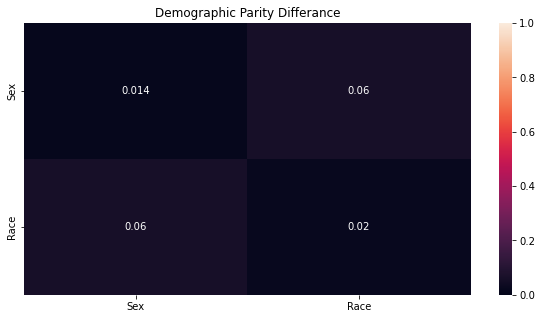

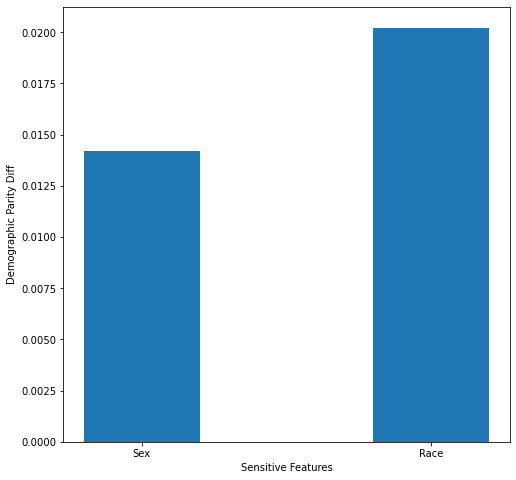

In [154]:
from fairlearn.metrics import demographic_parity_difference

dmpds = demographic_parity_difference(y_true=y_s,
                                    y_pred=y_pred_mitigated_sex_s,
                                    sensitive_features=df['sex'])
print('Demographic parity differences, Sex as Sensitive Feature =',dmpds)
dmpdr = demographic_parity_difference(y_true=y_s,
                                    y_pred=y_pred_mitigated_race_s,
                                     sensitive_features=df['race'])
print('Demographic parity differences, Race as Sensitive Feature = ',dmpdr)
dmpdrs = demographic_parity_difference(y_true=y_s,
                                    y_pred=y_pred_mitigated_race_sex_s,
                                    sensitive_features=df[["race",'sex']])

print('Demographic parity differences, (Race and Sex) as Sensitive Feature  = ',dmpdrs) 


data_diffrances=[[dmpds,dmpdrs],[dmpdrs,dmpdr]]
labels = ['Sex','Race']
df_CM = pd.DataFrame(data_diffrances, index = labels, columns = labels)
plt.figure(figsize = (10,5))
plt.title('Demographic Parity Differance')
sns.heatmap(df_CM, annot = True, vmin = 0, vmax = 1)
plt.show()

data_diagonal={'Sex':dmpds, 'Race':dmpdr}
keys = list(data_diagonal.keys())
values = list(data_diagonal.values())
fig = plt.figure(figsize = (8,8))
plt.bar(keys, values, width = 0.4)
plt.xlabel('Sensitive Features')
plt.ylabel('Demographic Parity Diff')
plt.show()

 # 2 ) CorrelationRemover + GridSearch

In [202]:
X_scg=df.drop('>50K',axis=1)
y_scg=df['>50K']
classifier = GradientBoostingClassifier()
classifier.fit(X_scg, y_scg)
y_pred_scg = classifier.predict(X_scg)

# CorrelationRemover

# Sex 

In [203]:
cr_sex_scg1 = CorrelationRemover(sensitive_feature_ids=['sex'])
cr_sex_scg1.fit(X_scg)

X_transform_sex_scg = cr_sex_scg1.transform(X_scg)

classifier = GradientBoostingClassifier()
classifier.fit(X_transform_sex_scg, y_scg)

y_pred_sex_scg = classifier.predict(X_transform_sex_scg)

# Race

In [204]:
cr_race_scg1 = CorrelationRemover(sensitive_feature_ids=['race'])
cr_race_scg1.fit(X_scg)

X_transform_race_scg = cr_race_scg1.transform(X_scg)

classifier1 = GradientBoostingClassifier()
classifier1.fit(X_transform_race_scg, y_scg)

y_pred_race_scg = classifier1.predict(X_transform_race_scg)

# Race&Sex

In [205]:
cr_race_sex_scg1 = CorrelationRemover(sensitive_feature_ids=['race','sex'])
cr_race_sex_scg1.fit(X_scg)

X_transform_race_sex_scg = cr_race_sex_scg1.transform(X_scg)

classifier2 = GradientBoostingClassifier()
classifier2.fit(X_transform_race_sex_scg, y_scg)

y_pred_race_sex_scg = classifier2.predict(X_transform_race_sex_scg)

# GridSearch

# Sex

In [206]:
 GS=GridSearch(
    LogisticRegression(solver="liblinear", fit_intercept=True),
    constraints=DemographicParity(),
    grid_size=31,
)
    
GS.fit(X_transform_sex_scg, y_scg, sensitive_features=df[['sex']])
predictors = GS.predictors_
y_pred_GS_mitigated_sex_scg = GS.predict(X_transform_sex_scg)

# Race 

In [207]:
 GS=GridSearch(
    LogisticRegression(solver="liblinear", fit_intercept=True),
    constraints=DemographicParity(),
    grid_size=31,
)
    
GS.fit(X_transform_race_scg, y_scg, sensitive_features=df[['race']])
predictors = GS.predictors_
y_pred_GS_mitigated_race_scg = GS.predict(X_transform_race_scg)

# Race&Sex

In [208]:
 GS=GridSearch(
    LogisticRegression(solver="liblinear", fit_intercept=True),
    constraints=DemographicParity(),
    grid_size=31,
)
    
GS.fit(X_transform_race_sex_scg, y_scg, sensitive_features=df[['race','sex']])
predictors = GS.predictors_
y_pred_GS_mitigated_race_sex_scg = GS.predict(X_transform_race_sex_scg)

The grid has 9 dimensions. It is not recommended to use more than 4, otherwise a prohibitively large grid size is required to explore the space thoroughly. For such cases consider using ExponentiatedGradient from the fairlearn.reductions module.
Generating a grid with 31 grid points. It is recommended to use at least 512 grid points. Please consider increasing grid_size.


# Demographic parity differences

Demographic parity differences, Sex as Sensitive Feature = 0.0228610124145779
Demographic parity differences, Race as Sensitive Feature =  0.06165671336769682
Demographic parity differences, (Race and Sex) as Sensitive Feature  =  0.49703786602454547


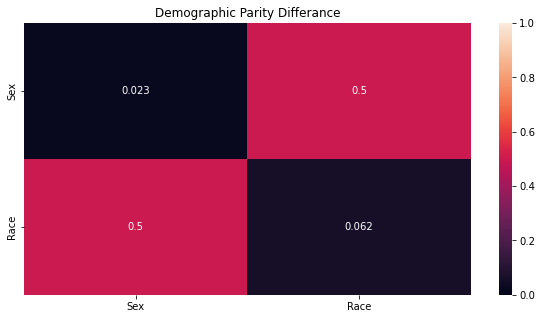

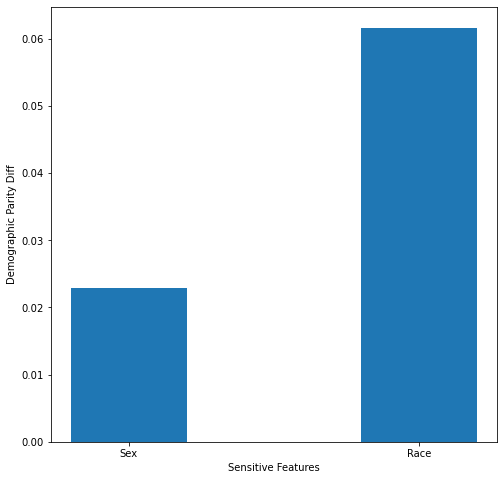

In [209]:
from fairlearn.metrics import demographic_parity_difference

dmpds = demographic_parity_difference(y_true=y_scg,
                                    y_pred=y_pred_GS_mitigated_sex_scg,
                                    sensitive_features=df['sex'])
print('Demographic parity differences, Sex as Sensitive Feature =',dmpds)
dmpdr = demographic_parity_difference(y_true=y_scg,
                                    y_pred=y_pred_GS_mitigated_race_scg,
                                     sensitive_features=df['race'])
print('Demographic parity differences, Race as Sensitive Feature = ',dmpdr)
dmpdrs = demographic_parity_difference(y_true=y_scg,
                                    y_pred=y_pred_GS_mitigated_race_sex_scg,
                                    sensitive_features=df[["race",'sex']])

print('Demographic parity differences, (Race and Sex) as Sensitive Feature  = ',dmpdrs) 


data_diffrances=[[dmpds,dmpdrs],[dmpdrs,dmpdr]]
labels = ['Sex','Race']
df_CM = pd.DataFrame(data_diffrances, index = labels, columns = labels)
plt.figure(figsize = (10,5))
plt.title('Demographic Parity Differance')
sns.heatmap(df_CM, annot = True, vmin = 0, vmax = 1)
plt.show()

data_diagonal={'Sex':dmpds, 'Race':dmpdr}
keys = list(data_diagonal.keys())
values = list(data_diagonal.values())
fig = plt.figure(figsize = (8,8))
plt.bar(keys, values, width = 0.4)
plt.xlabel('Sensitive Features')
plt.ylabel('Demographic Parity Diff')
plt.show()

# 3 ) CorrelationRemover + ThresholdOptimizer

In [210]:
X_sct=df.drop('>50K',axis=1)
y_sct=df['>50K']
classifier = GradientBoostingClassifier()
classifier.fit(X_sct, y_sct)
y_pred_sct = classifier.predict(X_sct)

# CorrelationRemover 

# Sex

In [211]:
cr_sex_sct1 = CorrelationRemover(sensitive_feature_ids=['sex'])
cr_sex_sct1.fit(X_scg)

X_transform_sex_sct = cr_sex_sct1.transform(X_sct)

classifier = GradientBoostingClassifier()
classifier.fit(X_transform_sex_sct, y_sct)

y_pred_sex_sct = classifier.predict(X_transform_sex_sct)

# Race

In [212]:
cr_race_sct1 = CorrelationRemover(sensitive_feature_ids=['race'])
cr_race_sct1.fit(X_sct)

X_transform_race_sct = cr_race_scg1.transform(X_sct)

classifier1 = GradientBoostingClassifier()
classifier1.fit(X_transform_race_sct, y_sct)

y_pred_race_sct = classifier1.predict(X_transform_race_sct)

# Race&Sex

In [213]:
cr_race_sex_sct1 = CorrelationRemover(sensitive_feature_ids=['race','sex'])
cr_race_sex_sct1.fit(X_sct)

X_transform_race_sex_sct = cr_race_sex_sct1.transform(X_sct)

classifier2 = GradientBoostingClassifier()
classifier2.fit(X_transform_race_sex_sct, y_sct)

y_pred_race_sex_sct = classifier2.predict(X_transform_race_sex_sct)

# ThresholdOptimizer

In [214]:
optimizer = ThresholdOptimizer(estimator=classifier, constraints='demographic_parity')

# Sex

In [215]:
optimizer.fit(X_transform_sex_sct,y_sct,sensitive_features=df[['sex']])
th_sex_y_pred_sct = optimizer.predict(X_transform_sex_sct, sensitive_features=df[['sex']])

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


# Race

In [216]:
optimizer.fit(X_transform_race_sct,y_sct,sensitive_features=df[['race']])
th_race_y_pred_sct = optimizer.predict(X_transform_race_sct, sensitive_features=df[['race']])

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


# Race&Sex

In [217]:
optimizer.fit(X_transform_race_sex_sct,y_sct,sensitive_features=df[['race','sex']])
th_racesex_y_pred_sct = optimizer.predict(X_transform_race_sex_sct,sensitive_features=df[['race','sex']])

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


# Demographic parity differences

Demographic parity differences, Sex as Sensitive Feature = 0.00238497524347947
Demographic parity differences, Race as Sensitive Feature =  0.01991682920546131
Demographic parity differences, (Race and Sex) as Sensitive Feature  =  0.10042674253200568


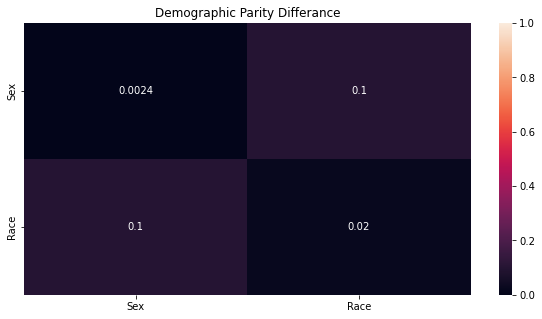

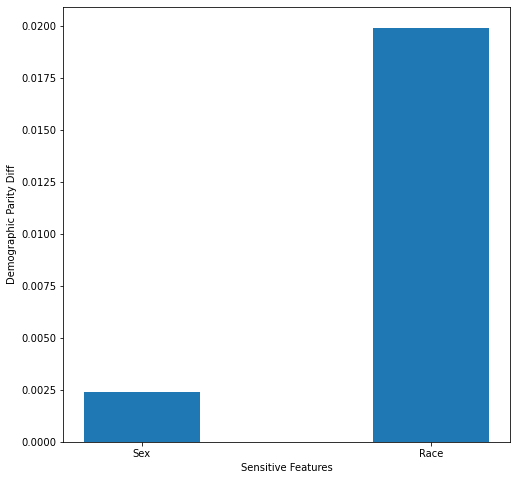

In [218]:
from fairlearn.metrics import demographic_parity_difference

dmpds = demographic_parity_difference(y_true=y_sct,
                                    y_pred=th_sex_y_pred_sct,
                                    sensitive_features=df['sex'])
print('Demographic parity differences, Sex as Sensitive Feature =',dmpds)
dmpdr = demographic_parity_difference(y_true=y_sct,
                                    y_pred=th_race_y_pred_sct,
                                     sensitive_features=df['race'])
print('Demographic parity differences, Race as Sensitive Feature = ',dmpdr)
dmpdrs = demographic_parity_difference(y_true=y_sct,
                                    y_pred=th_racesex_y_pred_sct,
                                    sensitive_features=df[["race",'sex']])

print('Demographic parity differences, (Race and Sex) as Sensitive Feature  = ',dmpdrs) 


data_diffrances=[[dmpds,dmpdrs],[dmpdrs,dmpdr]]
labels = ['Sex','Race']
df_CM = pd.DataFrame(data_diffrances, index = labels, columns = labels)
plt.figure(figsize = (10,5))
plt.title('Demographic Parity Differance')
sns.heatmap(df_CM, annot = True, vmin = 0, vmax = 1)
plt.show()

data_diagonal={'Sex':dmpds, 'Race':dmpdr}
keys = list(data_diagonal.keys())
values = list(data_diagonal.values())
fig = plt.figure(figsize = (8,8))
plt.bar(keys, values, width = 0.4)
plt.xlabel('Sensitive Features')
plt.ylabel('Demographic Parity Diff')
plt.show()

#  2 ) ExponentiateGradient + GridSearch

In [160]:
X_seg=df.drop('>50K',axis=1)
y_seg=df['>50K']
classifier = GradientBoostingClassifier()
classifier.fit(X_seg, y_seg)
y_pred_seg = classifier.predict(X_seg)

# Sex

In [162]:

np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = GradientBoostingClassifier()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X_seg, y_seg, sensitive_features=df[['sex']])
y_pred_mitigated_sex_seg = mitigator.predict(X_seg)

# Race

In [164]:
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = GradientBoostingClassifier()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X_seg, y_seg, sensitive_features=df[['race']])
y_pred_mitigated_race_seg = mitigator.predict(X_seg)

# Race&Sex

In [166]:
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = GradientBoostingClassifier()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X_seg, y_seg, sensitive_features=df[['race','sex']])
y_pred_mitigated_race_sex_seg = mitigator.predict(X_seg)

# GridSearch

# Sex

In [169]:
 GS=GridSearch(
    LogisticRegression(solver="liblinear", fit_intercept=True),
    constraints=DemographicParity(),
    grid_size=31,
)
    
GS.fit(X_seg, y_seg, sensitive_features=df[['sex']])
predictors = GS.predictors_
y_pred_GS_mitigated_sex_seg = GS.predict(X_seg)

# Race

In [171]:
 GS=GridSearch(
    LogisticRegression(solver="liblinear", fit_intercept=True),
    constraints=DemographicParity(),
    grid_size=31,
)
    
GS.fit(X_seg, y_seg, sensitive_features=df[['race']])
predictors = GS.predictors_
y_pred_GS_mitigated_race_seg = GS.predict(X_seg)

# Race&Sex

In [173]:
 GS=GridSearch(
    LogisticRegression(solver="liblinear", fit_intercept=True),
    constraints=DemographicParity(),
    grid_size=31,
)
    
GS.fit(X_seg, y_seg, sensitive_features=df[['race','sex']])
predictors = GS.predictors_
y_pred_GS_mitigated_race_sex_seg = GS.predict(X_seg)

The grid has 9 dimensions. It is not recommended to use more than 4, otherwise a prohibitively large grid size is required to explore the space thoroughly. For such cases consider using ExponentiatedGradient from the fairlearn.reductions module.
Generating a grid with 31 grid points. It is recommended to use at least 512 grid points. Please consider increasing grid_size.
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Demographic parity differences

Demographic parity differences, Sex as Sensitive Feature = 0.023607472201877623
Demographic parity differences, Race as Sensitive Feature =  0.10502781206812603
Demographic parity differences, (Race and Sex) as Sensitive Feature  =  0.06885276241278275


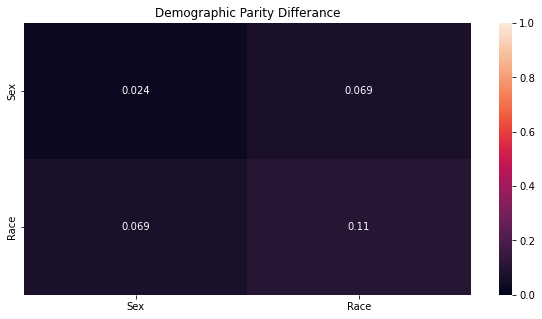

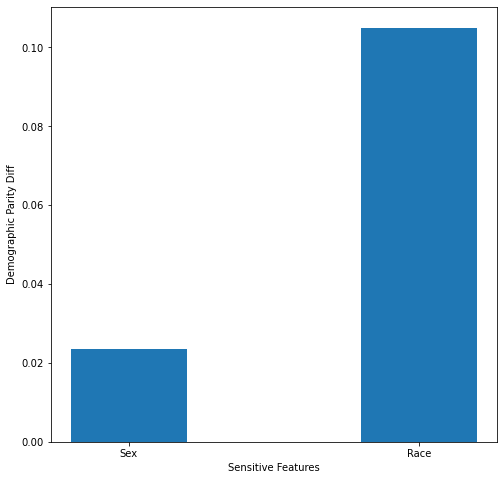

In [174]:
from fairlearn.metrics import demographic_parity_difference

dmpds = demographic_parity_difference(y_true=y_seg,
                                    y_pred=y_pred_GS_mitigated_sex_seg,
                                    sensitive_features=df['sex'])
print('Demographic parity differences, Sex as Sensitive Feature =',dmpds)
dmpdr = demographic_parity_difference(y_true=y_seg,
                                    y_pred=y_pred_GS_mitigated_race_seg,
                                     sensitive_features=df['race'])
print('Demographic parity differences, Race as Sensitive Feature = ',dmpdr)
dmpdrs = demographic_parity_difference(y_true=y_seg,
                                    y_pred=y_pred_GS_mitigated_race_sex_seg,
                                    sensitive_features=df[["race",'sex']])

print('Demographic parity differences, (Race and Sex) as Sensitive Feature  = ',dmpdrs) 


data_diffrances=[[dmpds,dmpdrs],[dmpdrs,dmpdr]]
labels = ['Sex','Race']
df_CM = pd.DataFrame(data_diffrances, index = labels, columns = labels)
plt.figure(figsize = (10,5))
plt.title('Demographic Parity Differance')
sns.heatmap(df_CM, annot = True, vmin = 0, vmax = 1)
plt.show()

data_diagonal={'Sex':dmpds, 'Race':dmpdr}
keys = list(data_diagonal.keys())
values = list(data_diagonal.values())
fig = plt.figure(figsize = (8,8))
plt.bar(keys, values, width = 0.4)
plt.xlabel('Sensitive Features')
plt.ylabel('Demographic Parity Diff')
plt.show()

#  3 ) GridSearch + ThresholdOptimizer

In [175]:
X_sgt=df.drop('>50K',axis=1)
y_sgt=df['>50K']
classifier = GradientBoostingClassifier()
classifier.fit(X_sgt, y_sgt)
y_pred_sgt = classifier.predict(X_sgt)

# GridSearch

# Sex

In [177]:
 GS=GridSearch(
    LogisticRegression(solver="liblinear", fit_intercept=True),
    constraints=DemographicParity(),
    grid_size=31,
)
    
GS.fit(X_sgt, y_sgt, sensitive_features=df[['sex']])
predictors = GS.predictors_
y_pred_GS_mitigated_sex_sgt = GS.predict(X_sgt)

# Race

In [179]:
 GS=GridSearch(
    LogisticRegression(solver="liblinear", fit_intercept=True),
    constraints=DemographicParity(),
    grid_size=31,
)
    
GS.fit(X_sgt, y_sgt, sensitive_features=df[['race']])
predictors = GS.predictors_
y_pred_GS_mitigated_race_sgt = GS.predict(X_sgt)

# Race&Sex

In [181]:
 GS=GridSearch(
    LogisticRegression(solver="liblinear", fit_intercept=True),
    constraints=DemographicParity(),
    grid_size=31,
)
    
GS.fit(X_sgt, y_sgt, sensitive_features=df[['race','sex']])
predictors = GS.predictors_
y_pred_GS_mitigated_race_sex_sgt = GS.predict(X_sgt)

The grid has 9 dimensions. It is not recommended to use more than 4, otherwise a prohibitively large grid size is required to explore the space thoroughly. For such cases consider using ExponentiatedGradient from the fairlearn.reductions module.
Generating a grid with 31 grid points. It is recommended to use at least 512 grid points. Please consider increasing grid_size.
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# ThresholdOptimizer

In [182]:
from fairlearn.postprocessing import ThresholdOptimizer

In [183]:
optimizer = ThresholdOptimizer(estimator=classifier, constraints='demographic_parity')

# Sex

In [185]:
optimizer.fit(X_sgt,y_sgt,sensitive_features=df[['sex']])
th_sex_y_pred_sgt = optimizer.predict(X_sgt, sensitive_features=df[['sex']])

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


# Race

In [187]:
optimizer.fit(X_sgt,y_sgt,sensitive_features=df[['race']])
th_race_y_pred_sgt = optimizer.predict(X_sgt, sensitive_features=df[['race']])

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


# Race&Sex

In [189]:
optimizer.fit(X_sgt,y_sgt,sensitive_features=df[['race','sex']])
th_racesex_y_pred_sgt = optimizer.predict(X_sgt,sensitive_features=df[['race','sex']])

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


# Demographic parity differences

Demographic parity differences, Sex as Sensitive Feature = 0.0025310818417882686
Demographic parity differences, Race as Sensitive Feature =  0.01763864611473065
Demographic parity differences, (Race and Sex) as Sensitive Feature  =  0.05467024396331191


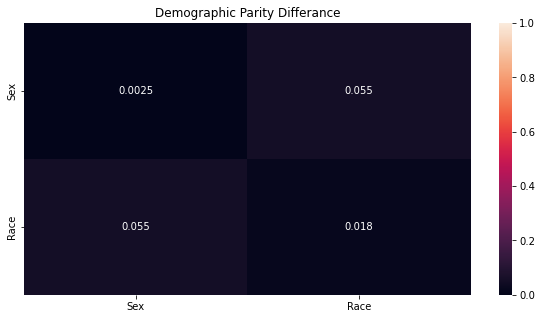

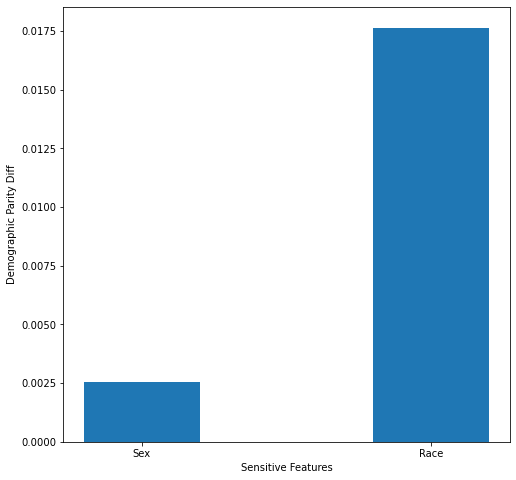

In [190]:
from fairlearn.metrics import demographic_parity_difference

dmpds = demographic_parity_difference(y_true=y_sgt,
                                    y_pred=th_sex_y_pred_sgt,
                                    sensitive_features=df['sex'])
print('Demographic parity differences, Sex as Sensitive Feature =',dmpds)
dmpdr = demographic_parity_difference(y_true=y_sgt,
                                    y_pred=th_race_y_pred_sgt,
                                     sensitive_features=df['race'])
print('Demographic parity differences, Race as Sensitive Feature = ',dmpdr)
dmpdrs = demographic_parity_difference(y_true=y_sgt,
                                    y_pred=th_racesex_y_pred_sgt,
                                    sensitive_features=df[["race",'sex']])

print('Demographic parity differences, (Race and Sex) as Sensitive Feature  = ',dmpdrs) 


data_diffrances=[[dmpds,dmpdrs],[dmpdrs,dmpdr]]
labels = ['Sex','Race']
df_CM = pd.DataFrame(data_diffrances, index = labels, columns = labels)
plt.figure(figsize = (10,5))
plt.title('Demographic Parity Differance')
sns.heatmap(df_CM, annot = True, vmin = 0, vmax = 1)
plt.show()

data_diagonal={'Sex':dmpds, 'Race':dmpdr}
keys = list(data_diagonal.keys())
values = list(data_diagonal.values())
fig = plt.figure(figsize = (8,8))
plt.bar(keys, values, width = 0.4)
plt.xlabel('Sensitive Features')
plt.ylabel('Demographic Parity Diff')
plt.show()

 #  4 ) ExponentiateGradient + ThresholdOptimizer

In [191]:
X_set=df.drop('>50K',axis=1)
y_set=df['>50K']
classifier = GradientBoostingClassifier()
classifier.fit(X_set, y_set)
y_pred_set = classifier.predict(X_set)

# ExponentiateGradient

# Sex 

In [192]:

np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = GradientBoostingClassifier()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X_set, y_set, sensitive_features=df[['sex']])
y_pred_mitigated_sex_set = mitigator.predict(X_set)

# Race

In [193]:
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = GradientBoostingClassifier()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X_set, y_set, sensitive_features=df[['race']])
y_pred_mitigated_race_set = mitigator.predict(X_set)

# Race&Sex

In [194]:
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = GradientBoostingClassifier()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X_set, y_set, sensitive_features=df[['race','sex']])
y_pred_mitigated_race_sex_set = mitigator.predict(X_set)

 # ThresholdOptimizer

In [195]:
optimizer = ThresholdOptimizer(estimator=classifier, constraints='demographic_parity')

 # Sex

In [196]:
optimizer.fit(X_set,y_set,sensitive_features=df[['sex']])
th_sex_y_pred_set = optimizer.predict(X_set, sensitive_features=df[['sex']])

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


# Race

In [197]:
optimizer.fit(X_set,y_set,sensitive_features=df[['race']])
th_race_y_pred_set = optimizer.predict(X_set, sensitive_features=df[['race']])

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


# Race&Sex

In [198]:
optimizer.fit(X_set,y_set,sensitive_features=df[['race','sex']])
th_racesex_y_pred_set = optimizer.predict(X_set,sensitive_features=df[['race','sex']])

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


Demographic parity differences, Sex as Sensitive Feature = 0.00108256814096086
Demographic parity differences, Race as Sensitive Feature =  0.02205398288347596
Demographic parity differences, (Race and Sex) as Sensitive Feature  =  0.0486132876990146


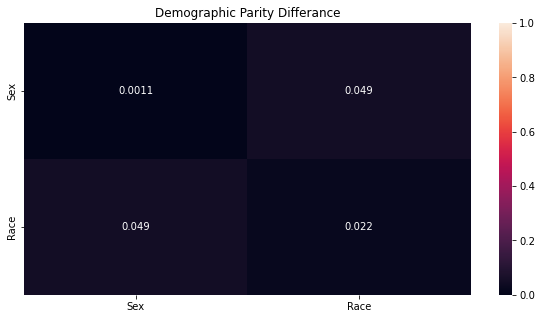

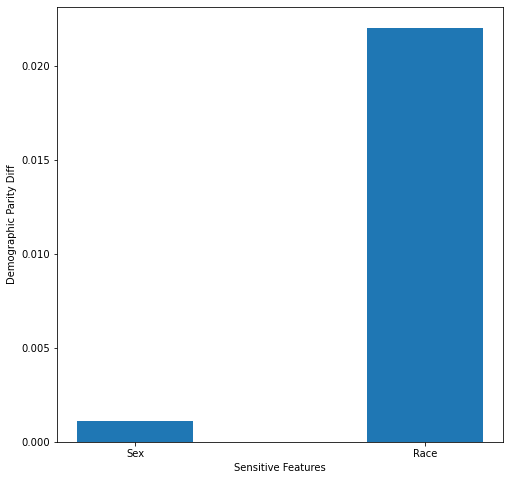

In [199]:
from fairlearn.metrics import demographic_parity_difference

dmpds = demographic_parity_difference(y_true=y_set,
                                    y_pred=th_sex_y_pred_set,
                                    sensitive_features=df['sex'])
print('Demographic parity differences, Sex as Sensitive Feature =',dmpds)
dmpdr = demographic_parity_difference(y_true=y_set,
                                    y_pred=th_race_y_pred_set,
                                     sensitive_features=df['race'])
print('Demographic parity differences, Race as Sensitive Feature = ',dmpdr)
dmpdrs = demographic_parity_difference(y_true=y_set,
                                    y_pred=th_racesex_y_pred_set,
                                    sensitive_features=df[["race",'sex']])

print('Demographic parity differences, (Race and Sex) as Sensitive Feature  = ',dmpdrs) 


data_diffrances=[[dmpds,dmpdrs],[dmpdrs,dmpdr]]
labels = ['Sex','Race']
df_CM = pd.DataFrame(data_diffrances, index = labels, columns = labels)
plt.figure(figsize = (10,5))
plt.title('Demographic Parity Differance')
sns.heatmap(df_CM, annot = True, vmin = 0, vmax = 1)
plt.show()

data_diagonal={'Sex':dmpds, 'Race':dmpdr}
keys = list(data_diagonal.keys())
values = list(data_diagonal.values())
fig = plt.figure(figsize = (8,8))
plt.bar(keys, values, width = 0.4)
plt.xlabel('Sensitive Features')
plt.ylabel('Demographic Parity Diff')
plt.show()

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>],
       [<AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>]], dtype=object)

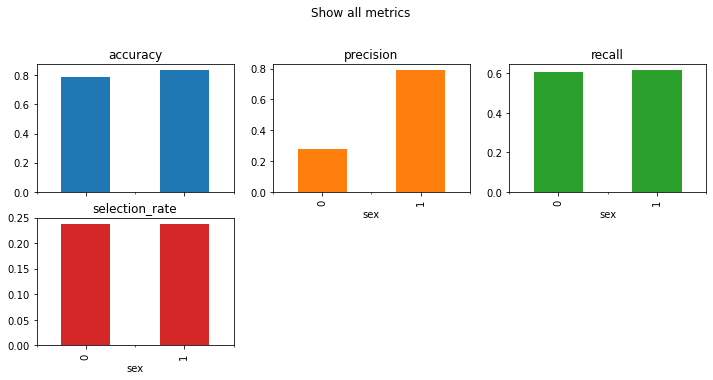

In [219]:
metric_frame_thp_sexw = MetricFrame(metrics=metrics,
                           y_true=y_set,
                           y_pred=th_sex_y_pred_set,
                           sensitive_features=df[['sex']])
metric_frame_thp_sexw.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>],
       [<AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>]], dtype=object)

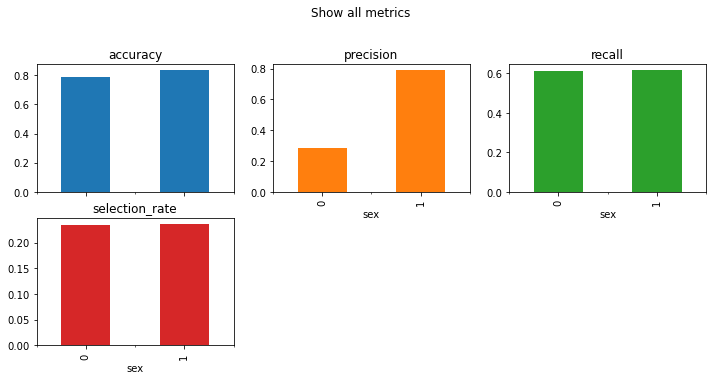

In [220]:
metric_frame_thp_sexw1 = MetricFrame(metrics=metrics,
                           y_true=y_sgt,
                           y_pred=th_sex_y_pred_sgt,
                           sensitive_features=df[['sex']])
metric_frame_thp_sexw1.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'selection_rate'}, xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>],
       [<AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>]], dtype=object)

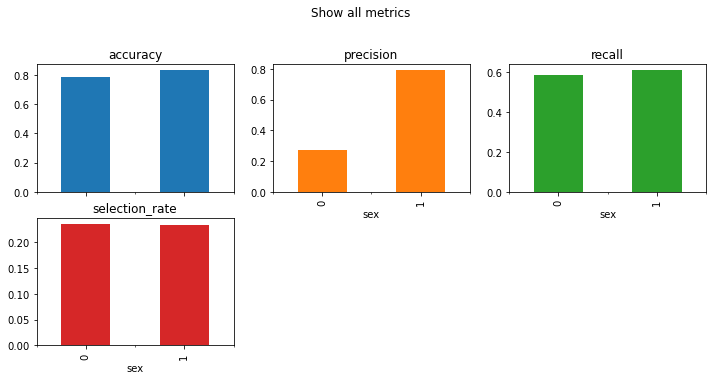

In [221]:

metric_frame_thp_sexwq1 = MetricFrame(metrics=metrics,
                           y_true=y_sct,
                           y_pred=th_sex_y_pred_sct,
                           sensitive_features=df[['sex']])
metric_frame_thp_sexwq1.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)
